# Predictive Maintenance Analysis

Src: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020/data

- Given the operational parameters and machine states available in the dataset, can we identify patterns or conditions indicative of an impending failure?

>> Hypothesis: Operational parameters and machine states contain discernible patterns or conditions that can be used to predict impending machine failures with significant accuracy.

- Can air and process temperatures predict machine failure?

>> Hypothesis: Extreme values of air and process temperatures are strong predictors of imminent machine failure.

- Is there a predictive relationship between operational parameters and specific failure types?

>> Hypothesis: Certain operational parameters are closely associated with specific types of failures, enabling the development of targeted preventive measures.

In [273]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, label_binarize
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import ttest_ind, mannwhitneyu
import plotly.graph_objects as go
import dataframe_image as dfi


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, classification_report, precision_score, precision_recall_curve, auc, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline








## Load Data

In [274]:
pred_df = pd.read_csv('../data/ai4i2020.csv')

## Pre-processing



### Let's understand the basic structure of the dataset

* What types of information do we have?

In [275]:
pred_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [276]:
# Save the DataFrame as an image
import dataframe_image as dfi

df_styled = pred_df.head().style.background_gradient() # Styling for better visualization

# Save the styled DataFrame as an image
dfi.export(df_styled, '../img/pred_df_head.png')

### This dataset tracks manufacturing process parameters and outcomes.
There are `14 columns` in the dataset:
- `UDI`: Sequential unique identifier.
- `Product ID`: Alphanumeric product codes.
- `Type`: Categorical, indicating product type ('M', 'L').
- `Air temperature [K]` and `Process temperature [K]`: Numerical, in Kelvin, showing controlled temperatures.
- `Rotational speed [rpm]`: Numerical, varying speeds.
- `Torque [Nm]`: Numerical, varying torque values.
- `Tool wear [min]`: Numerical, cumulative tool wear.
- `Machine failure`: Binary, indicating if a failure occurred (0 in sample).
- `TWF` (tool wear failure ), `HDF` (heat dissipation failure), `PWF` (power failure), `OSF`(overstrain failure), `RNF` (random failures): Binary, specific conditions or failures modes.

* What data types are the different columns?

In [277]:
pred_df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


- Columns span various data types, including `integers`, `floats`, and `objects`. 

### What is the shape of the dataset?

In [278]:
pred_df.shape

(10000, 14)

### How many missing / nan values are in the data?

In [279]:
pred_df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

It's a fully populated without missing values. 
- The `UDI` column, being an identifier, can be dropped.


### Are there any noticeable patterns in the data?

**Useful tools**: `.describe()`, `.info()', `Scatter matrix / Pairplot` & `.corr()`

In [280]:
pred_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


- There are `10,000` entries in the dataset.
- `Rotational speed [rpm]` and `Torque [Nm]`: Their wide ranges suggest variability that could impact machine performance or failure rates.
- `Tool wear [min]`: The progression of tool wear over time could be key in predicting maintenance needs.
- `Machine failure` and specific failure types (`TWF, HDF, PWF, OSF, RNF`): Low occurrence rates indicate these are critical but rare events, warranting deeper analysis to understand triggers or patterns. It might be a better idea to combibe the specific failure types columns later on for better analysis 

In [281]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

## Visualize distribution

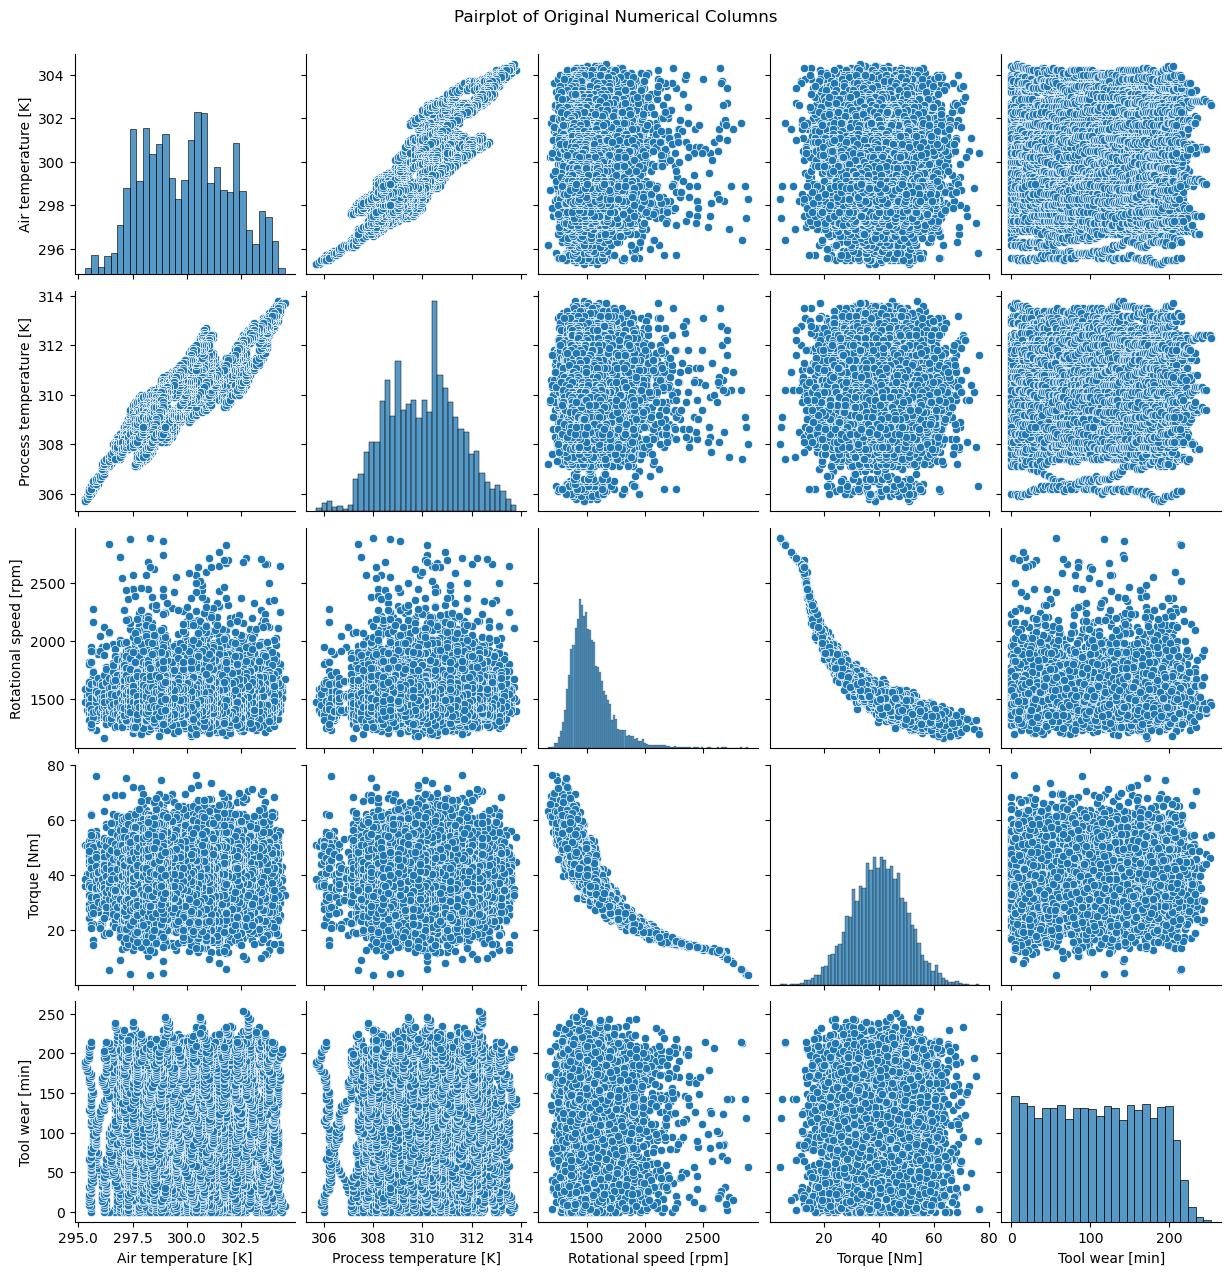

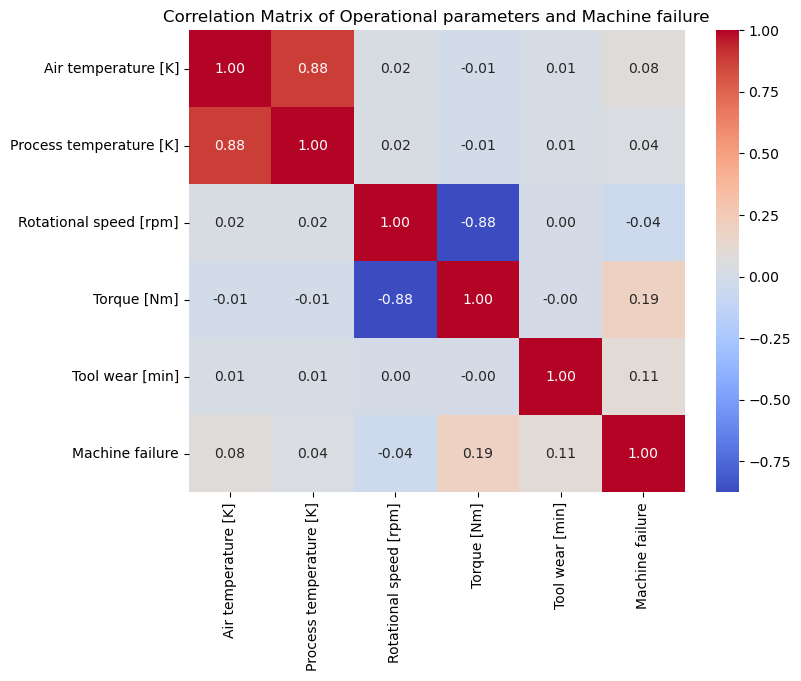

In [282]:
# Identify numerical columns (excluding binary columns)
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Pairplot of Original Numerical Columns
sns.pairplot(pred_df[numerical_cols])
plt.suptitle('Pairplot of Original Numerical Columns', y=1.02)
plt.show()

# Correlation Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pred_df[numerical_cols + ['Machine failure']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Operational parameters and Machine failure')
plt.show()

## Processing

### 1. Let's drop `UDI` column

In [283]:
if 'UDI' in pred_df.columns:
    pred_df.drop('UDI', axis=1, inplace=True)
pred_df.head(80)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,L47255,L,298.8,308.9,1379,46.7,204,0,0,0,0,0,0
76,L47256,L,298.8,308.9,1461,47.9,206,0,0,0,0,0,0
77,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
78,L47258,L,298.8,308.9,1398,51.5,0,0,0,0,0,0,0


### 2. Given `Machine failure` column tracks machine status ( 0 or 1), combining failure types into a single column might be a good idea.
- Combine `TWF`, `HDF`, `PWF`, `OSF`, & `RNF` into a new column, `Failure type`, then drop the combined columns

In [284]:
# Combine failure types into a single column
pred_df_cleaned = pd.DataFrame(pred_df)
def combine_failures(row):
    failures = []
    if row['TWF']: failures.append('TWF')
    if row['HDF']: failures.append('HDF')
    if row['PWF']: failures.append('PWF')
    if row['OSF']: failures.append('OSF')
    if row['RNF']: failures.append('RNF')
    return ', '.join(failures) if failures else 'No Failure'

# Apply the function to each row
pred_df_cleaned['Failure type'] = pred_df.apply(combine_failures, axis=1)

# Drop the original failure type columns
pred_df_cleaned.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

pred_df_cleaned.head(80)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...
75,L47255,L,298.8,308.9,1379,46.7,204,0,No Failure
76,L47256,L,298.8,308.9,1461,47.9,206,0,No Failure
77,L47257,L,298.8,308.9,1455,41.3,208,1,TWF
78,L47258,L,298.8,308.9,1398,51.5,0,0,No Failure


In [285]:
# Keep a copy of the cleaned dataframe
unbootstrapped_pred_df_cleaned = pred_df_cleaned.copy()
unbootstrapped_pred_df_cleaned.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## We earlier saw in the pairplot that the data isn't normalized. 

- Use `Bootstrapping` techniques to normalize the data

- Visualize the distribution

In [286]:
def bootstrap_resample(data, n_bootstrap=1000):
    """Perform bootstrapping on the data and return the sample means."""
    bootstrap_means = np.zeros(n_bootstrap)
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means[i] = np.mean(sample)
    return bootstrap_means

In [287]:
# Columns to bootstrap
columns_to_bootstrap = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Initialize a dictionary to hold bootstrapped means for each column
bootstrap_results = {}

# Perform bootstrapping for each column
for column in columns_to_bootstrap:
    bootstrap_means = bootstrap_resample(pred_df_cleaned[column])
    bootstrap_results[column] = bootstrap_means



In [288]:
fig = make_subplots(rows=len(columns_to_bootstrap)//2 + len(columns_to_bootstrap)%2, cols=2, subplot_titles=[f'Bootstrapped Means for {column}' for column in columns_to_bootstrap])

for i, column in enumerate(columns_to_bootstrap):
    overall_mean = pred_df_cleaned[column].mean()  # Calculate the overall mean for the column
    # Determine the row and column position for the current subplot
    row = i // 2 + 1
    col = i % 2 + 1
    # Create histogram for the current column
    histogram = go.Histogram(x=bootstrap_results[column], name=column)
    fig.add_trace(histogram, row=row, col=col)
    # Add a vertical line for the overall mean
    fig.add_vline(x=overall_mean, line_color="red", line_dash="dash", annotation_text=f"Overall Mean: {overall_mean:.2f}", 
                  annotation_position="top right", row=row, col=col)

fig.update_layout(height=1000, width=1200, title_text="Bootstrapped Means Visualization", showlegend=False, margin=dict(l=20, r=20, t=100, b=20))

fig.show()

fig.write_image('../img/bootstrapped_means1.png')

Let's visualize operational parameters and machine state in the data (State `0` indicates no failure). 

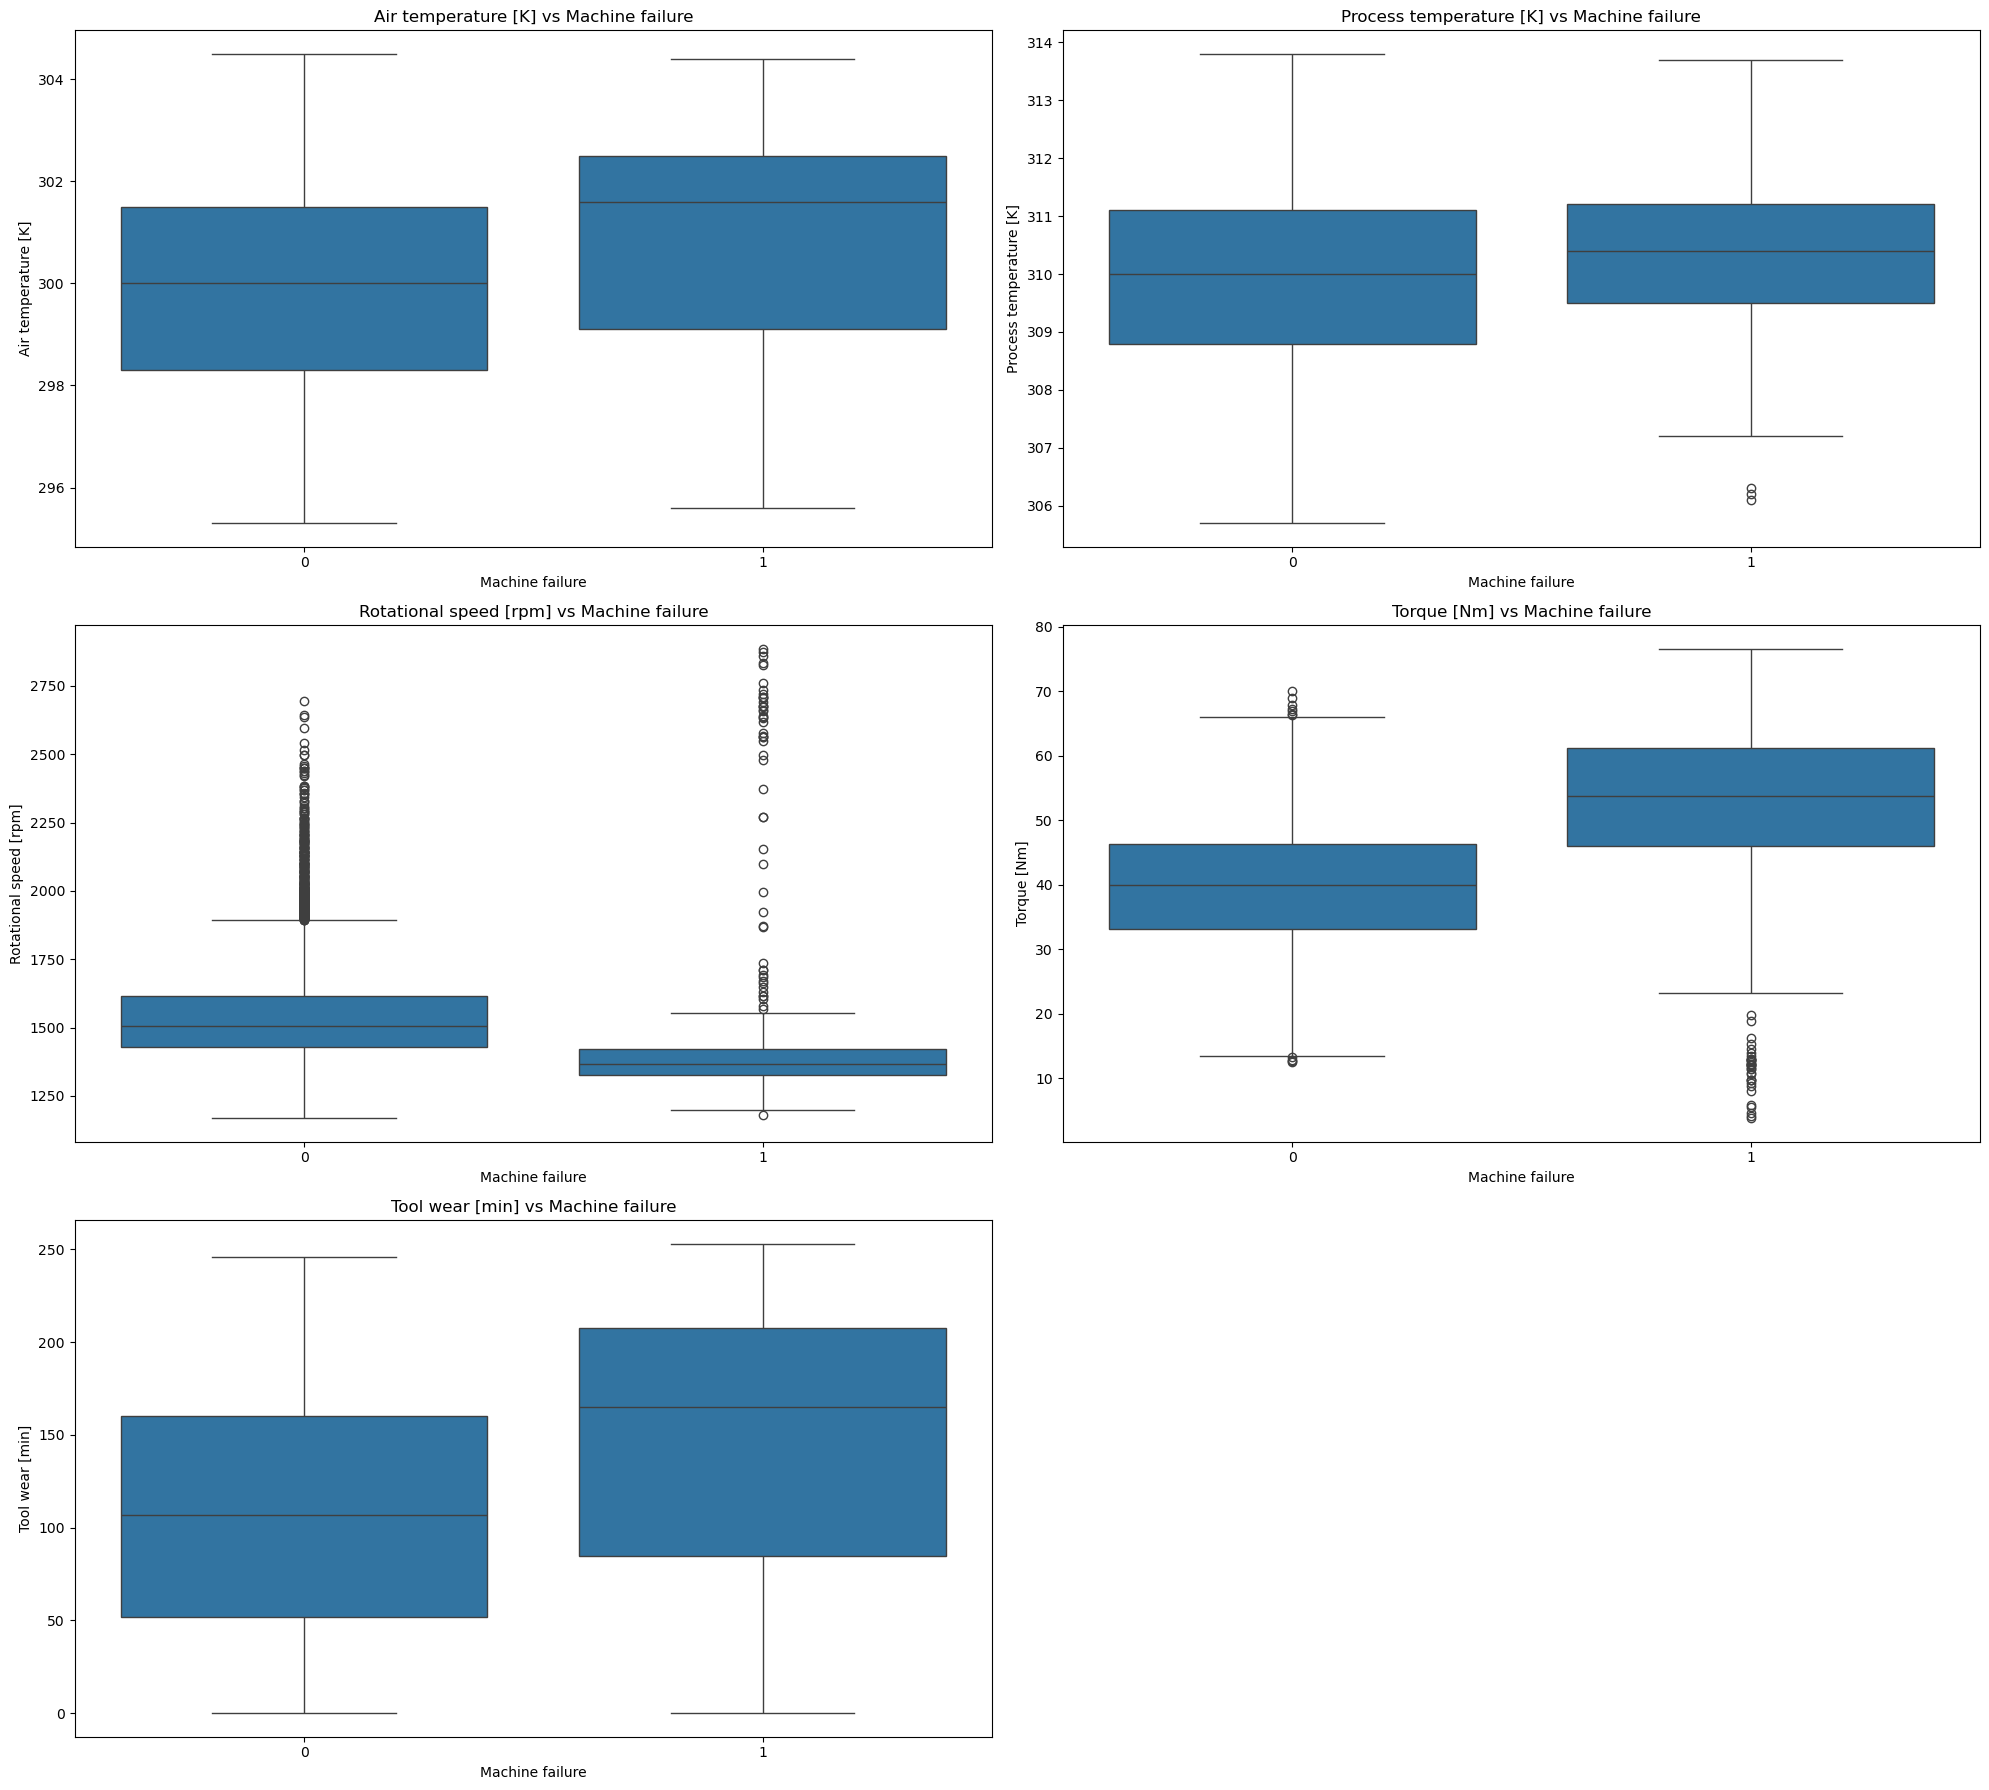

In [289]:
# Initialize the subplot
fig, axes = plt.subplots(3, 2, figsize=(20, 18)) 
axes = axes.flatten()  

# Iterate through each operational parameter
for i, column in enumerate(columns_to_bootstrap):
    sns.boxplot(x='Machine failure', y=column, data=pred_df_cleaned, ax=axes[i])
    axes[i].set_title(f'{column} vs Machine failure')
    

# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()

# Save the plot as an image
plt.savefig('../img/operational_parameters_vs_failure.png')
plt.show()


There are some outliers in `Rotational Speed` and `Torque`columns. However, we'd assume those outliers are legitimately present and they might have a direct correlation with machine failure. 

### We can further check the percentage of different failure types distribution in the data

In [290]:
fig = px.histogram(pred_df_cleaned, x='Failure type', text_auto=True, histnorm='percent')
fig.update_layout(yaxis_title='Percentage (%)')
fig.update_layout(title_text='Distribution of Failure Types')
fig.show()

**Findings:**
- Machines have an uptime of approximately 97%.
- `HDF` (Heat Dissipation Failure) and `PWF` (Power Failure) are the most common types of failures.



### What is the average distribution between the operational parameters and failure types?

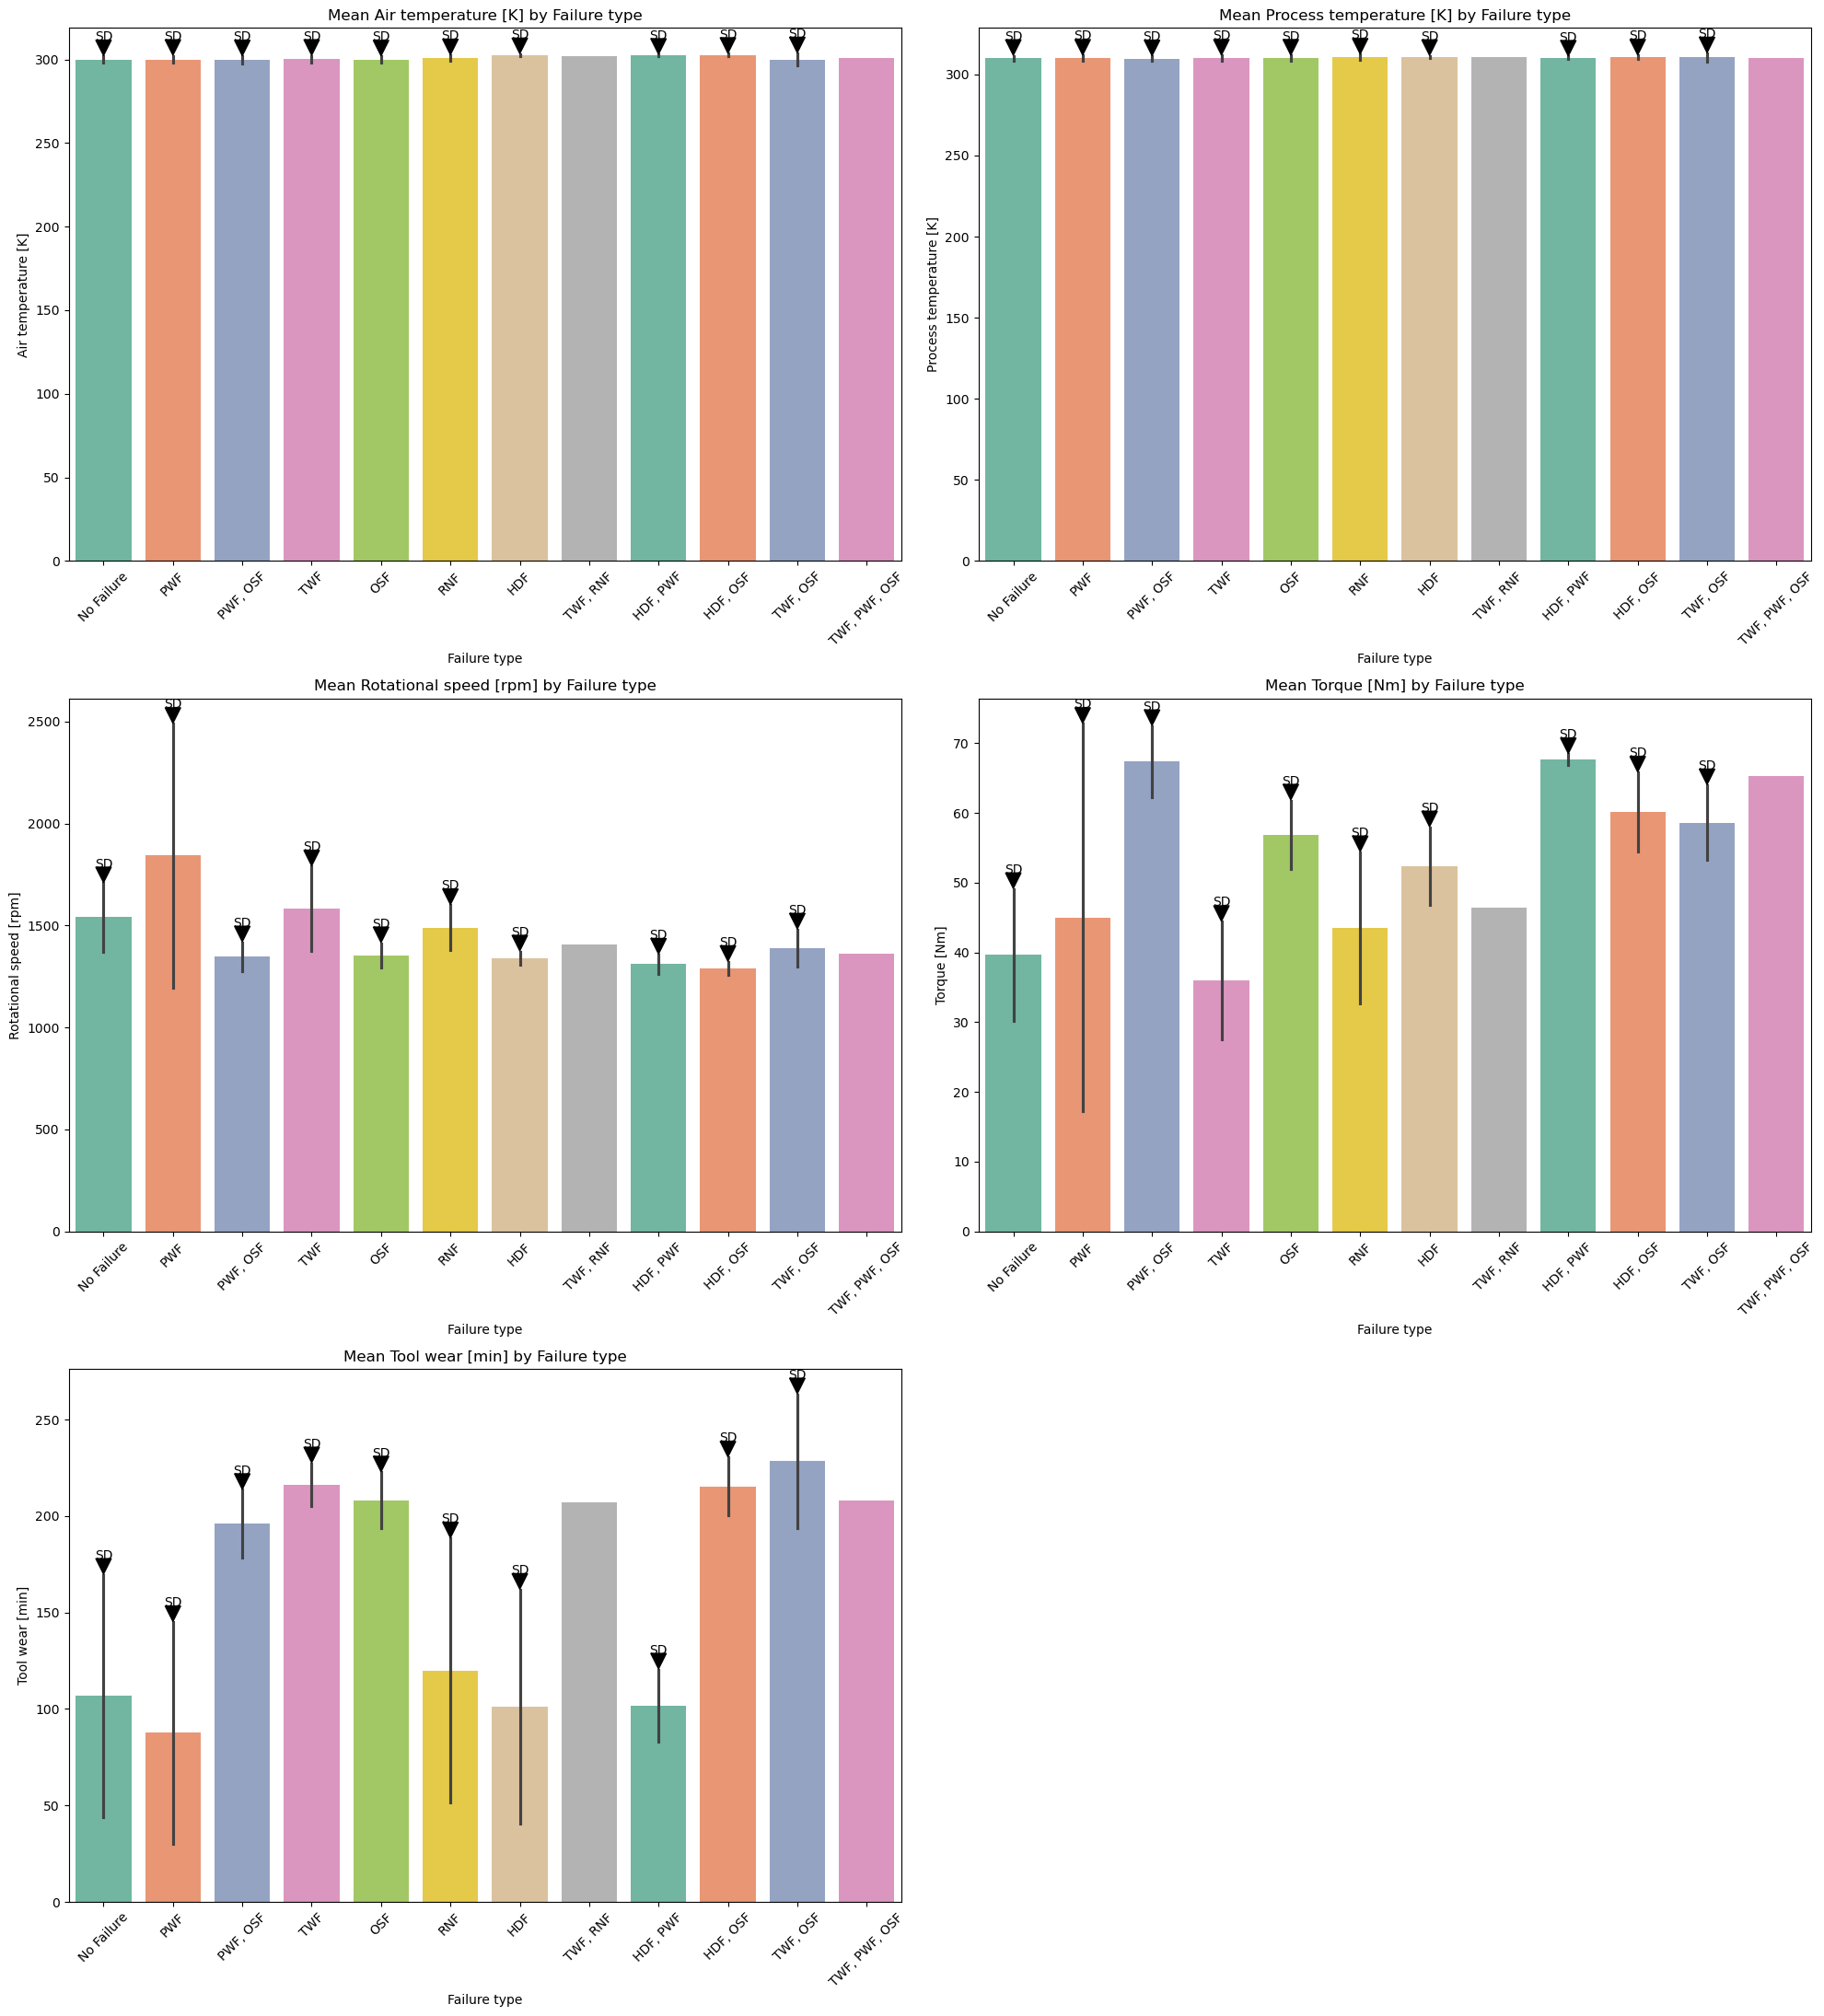

In [291]:
# Initialize the subplot
fig, axes = plt.subplots(3, 2, figsize=(20, 22))  
axes = axes.flatten()  # For easy iteration

# Iterate through each operational parameter to create bar plots
for i, column in enumerate(columns_to_bootstrap):
    
    # Create the bar plot
    sns.barplot(x='Failure type', y=column, hue='Failure type', data=pred_df_cleaned, ax=axes[i], palette='Set2', errorbar='sd', legend=False)
    axes[i].set_title(f'Mean {column} by Failure type')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Calculate mean and standard deviation for annotations
    for failure_type in pred_df_cleaned['Failure type'].unique():
        subset = pred_df_cleaned[pred_df_cleaned['Failure type'] == failure_type]
        mean = subset[column].mean()
        sd = subset[column].std()
        
        # Annotate error bar per subplot
        axes[i].annotate('SD', xy=(failure_type, mean + sd), xytext=(0, 10),
                         textcoords='offset points', ha='center', va='bottom',
                         arrowprops=dict(facecolor='black', shrink=0.05))

# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Findings:
- `Air temperature [K]`: It might be ideal to convert from Kelvin to Celcius and compare results
- `Process temperature [K]`: Likewise, convert from K to C
- `Rotational speed [rpm]`: We can identify some patterns with `PWF (power failure)` being the common when rotational speed is higher than normal
- `Torque [Nm]`: Torque of `~40 Nm (Newton-meters)` appears to be the normal with extreme lows and highs leading to machine failure
- `Tool wear [min]`: On average, 100 minutes is the duration before failure of certain type occurs.


### Let's convert values `Temperature' columns to Celcius from Kelvin

In [292]:

# Create a copy of pred_df_cleaned
pred_df_cleaned_celcius = pred_df_cleaned.copy()

columns_to_plot = ['Air temperature [C]', 'Process temperature [C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Convert temperatures from Kelvin to Celsius
pred_df_cleaned_celcius[['Air temperature [C]', 'Process temperature [C]']] = pred_df_cleaned_celcius[['Air temperature [K]', 'Process temperature [K]']] - 273.15

# Define the new column order, replacing Kelvin columns with Celsius columns
new_column_order = ['Product ID', 'Type', 'Air temperature [C]', 'Process temperature [C]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
                    'Machine failure', 'Failure type']

# Reorder/reindex the columns
pred_df_cleaned_celcius = pred_df_cleaned_celcius.reindex(columns=new_column_order)

pred_df_cleaned_celcius.head()

,Product ID,Type,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure type
0,M14860,M,24.95,35.45,1551,42.8,0,0,No Failure
1,L47181,L,25.05,35.55,1408,46.3,3,0,No Failure
2,L47182,L,24.95,35.35,1498,49.4,5,0,No Failure
3,L47183,L,25.05,35.45,1433,39.5,7,0,No Failure
4,L47184,L,25.05,35.55,1408,40.0,9,0,No Failure


### Replot the distribution of operational parameters vs failure types using the converted values.

In [293]:


# Create a list of unique failure types for color mapping
failure_types = pred_df_cleaned['Failure type'].unique()
colors = px.colors.qualitative.Set2

# Create a subplot figure
fig = make_subplots(rows=3, cols=2, subplot_titles=[f'Mean {column} by Failure type' for column in columns_to_bootstrap])

# Flatten the subplot structure for easy iteration
axes = [(r, c) for r in range(1, 4) for c in range(1, 3)]

# Iterate through each operational parameter to create bar plots
for i, column in enumerate(columns_to_bootstrap):
    # Filter the DataFrame for the current column and calculate mean and standard deviation
    df_grouped = pred_df_cleaned.groupby('Failure type')[column].agg(['mean', 'std']).reset_index()
    
    # Create the bar plot for the current column
    for j, failure_type in enumerate(failure_types):
        # Find the mean and standard deviation for the current failure type
        mean = df_grouped.loc[df_grouped['Failure type'] == failure_type, 'mean'].values[0]
        std = df_grouped.loc[df_grouped['Failure type'] == failure_type, 'std'].values[0]
        
        # Add a bar for the current failure type
        fig.add_trace(go.Bar(x=[failure_type], y=[mean], name=failure_type, marker_color=colors[j % len(colors)],
                             error_y=dict(type='data', array=[std], visible=True)),
                      row=axes[i][0], col=axes[i][1])
    
    # Update the layout for the current subplot
    fig.update_xaxes(title_text="Failure Type", row=axes[i][0], col=axes[i][1])
    fig.update_yaxes(title_text=column, row=axes[i][0], col=axes[i][1])

# Update the layout for the entire figure
fig.update_layout(height=1000, width=1200, showlegend=False, title_text="Mean Operational Parameters by Failure Type")

# Show the figure
fig.show()

fig.write_image('../img/mean_process_by_failtype1.png')

**Findings**:
- `Air temperature [K]`: Slight variation on machine temperature seems to correlate with most of failure types
- `Process temperature [K]`: Process temperature appears to be having minimal effect on failure types if visualized using a bar plot.



### Compare distribution of failure types across all parameters

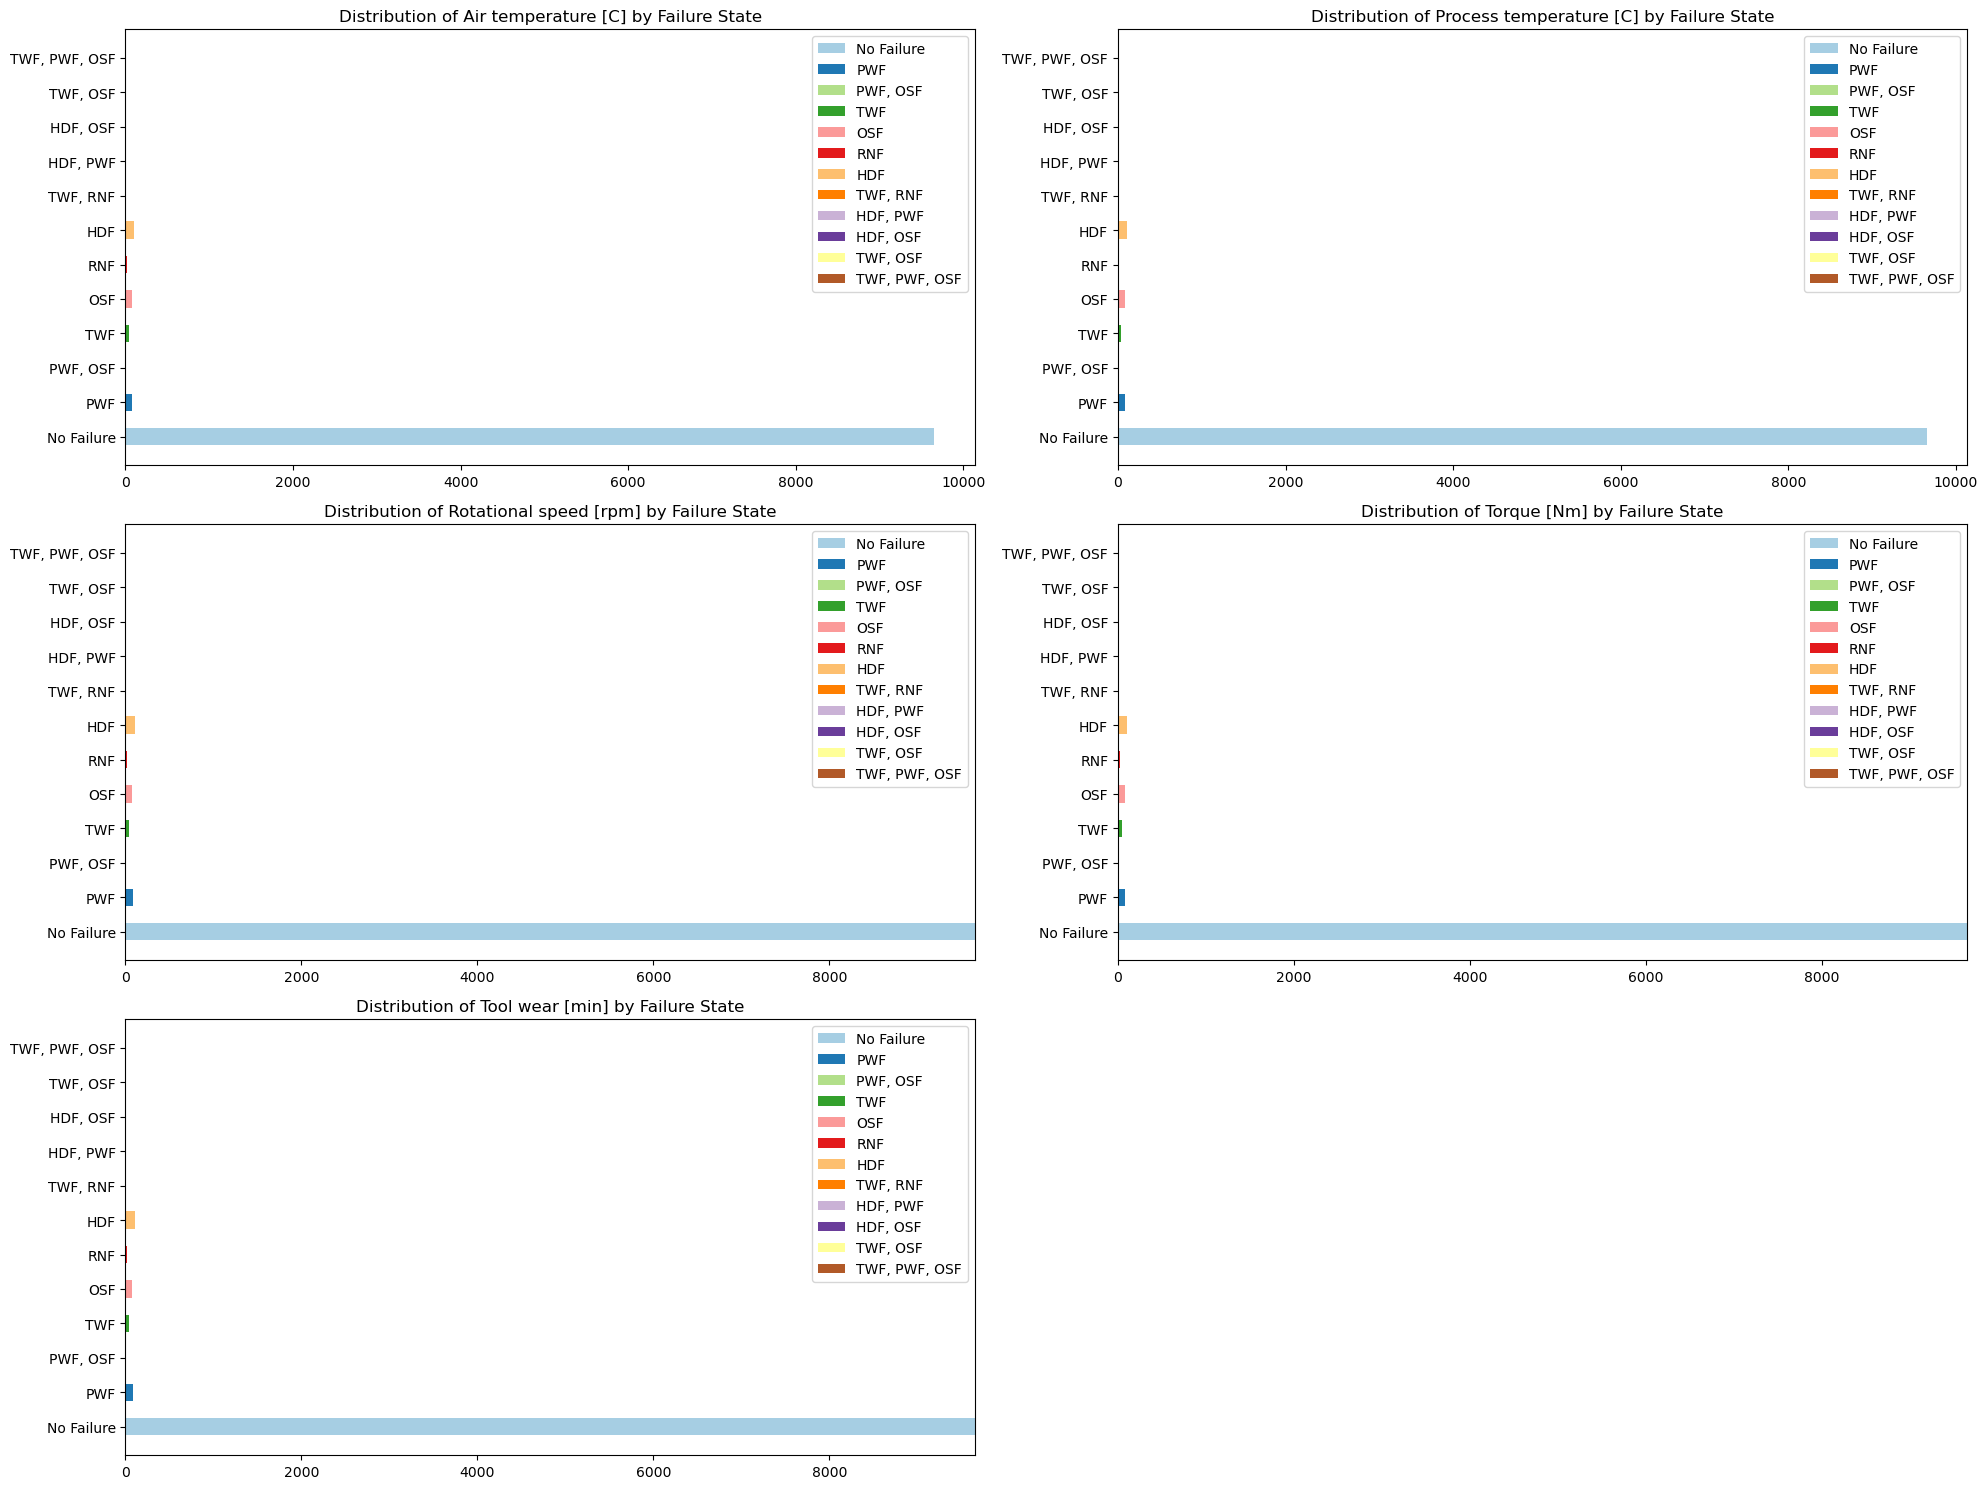

In [294]:
# Define a custom palette
base_palette = sns.color_palette('Paired')
custom_palette = {failure_type: color for failure_type, color in zip(pred_df_cleaned_celcius['Failure type'].unique(), base_palette)}

# Adjust subplot grid
n_rows = 3
n_cols = 2  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))  

# Flatten axes for easy iteration
axes = axes.flatten()

# Iterate through each operational parameter to create stacked bar plots
for i, column in enumerate(columns_to_plot):
    ax = axes[i]  
    # Prepare data for stacked bar plot
    data = pred_df_cleaned_celcius.groupby(['Failure type', column]).size().unstack(fill_value=0)
    data_cum = data.cumsum(axis=1)
    
    # Plot bars
    for failure_type, color in custom_palette.items():
        widths = data.loc[failure_type, :].values
        starts = data_cum.loc[failure_type, :] - widths
        ax.barh(failure_type, widths, left=starts, height=0.5, label=failure_type, color=color)
    
    ax.set_title(f'Distribution of {column} by Failure State')
    ax.legend()

# Remove the last empty subplot 
if len(columns_to_plot) % n_cols != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

**Notably, "No Failure" `Failure type` state dominates cementing our earlier findings of about 97% uptime.**

### Visualizing the above from another perspective might help us look deeper into how each failure type correlates with operational parameters. 

### Filter out `No Failure` and plot the distribution of failure types across all operational parameters

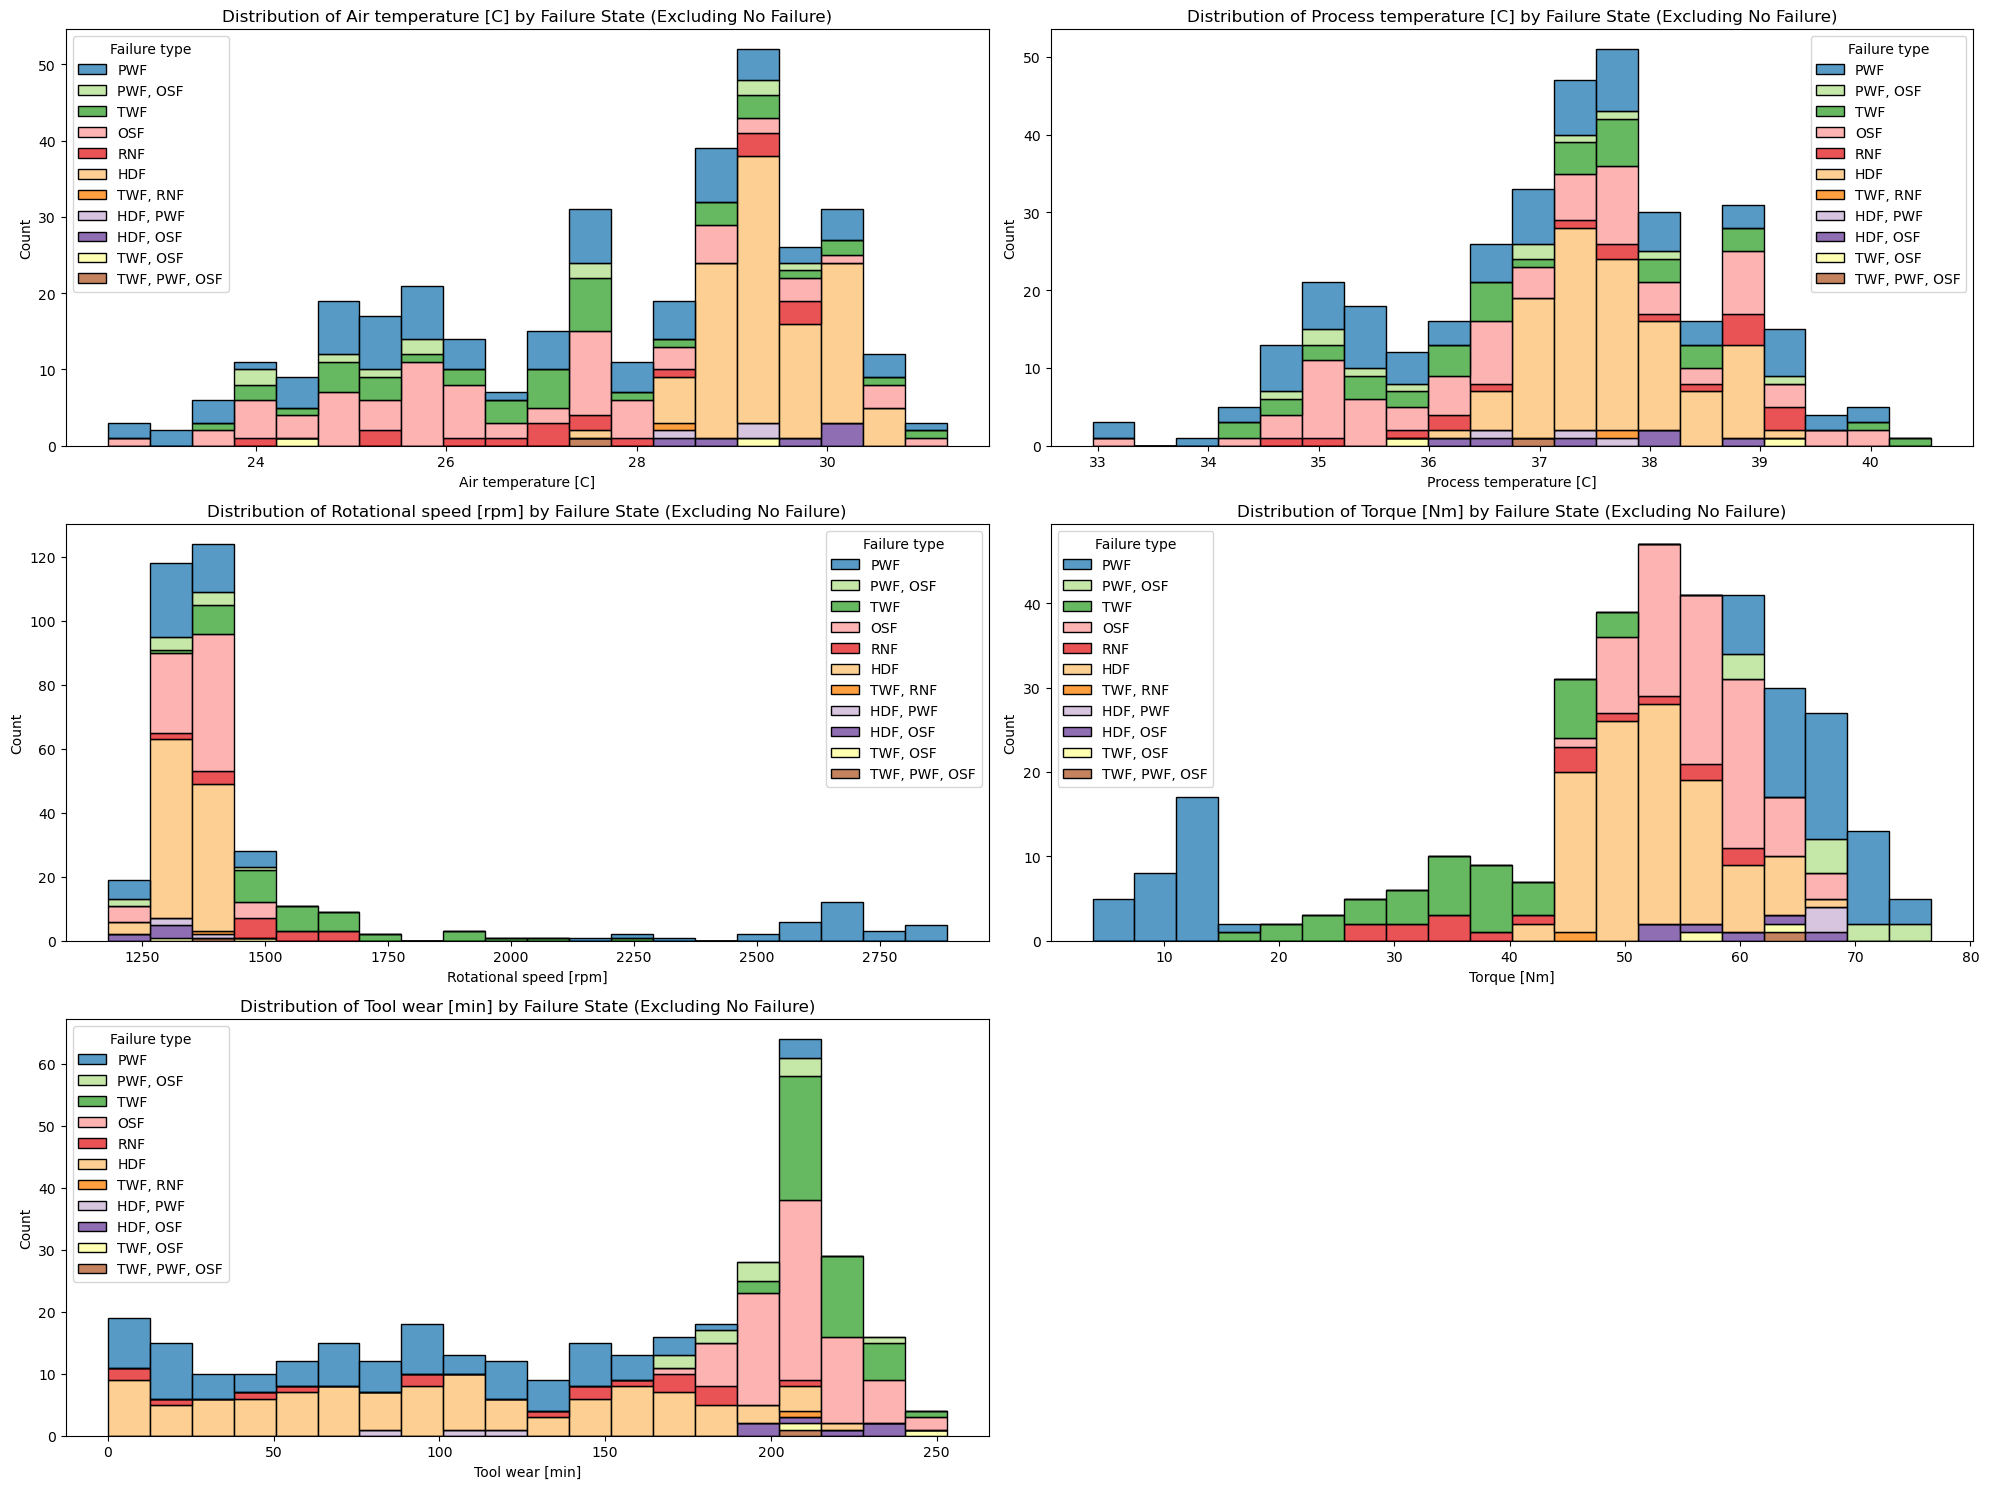

In [295]:
# Filter out 'No Failure' data
filtered_df = pred_df_cleaned_celcius[pred_df_cleaned_celcius['Failure type'] != 'No Failure']

# Setup for subplots
# Setup for subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

# Iterate through each operational parameter to create histograms
for i, column in enumerate(columns_to_plot):
    ax = sns.histplot(data=filtered_df, x=column, hue='Failure type', multiple="stack", palette=custom_palette, ax=axes[i], bins=20)
    axes[i].set_title(f'Distribution of {column} by Failure State (Excluding No Failure)')

if len(columns_to_plot) % 2 != 0:
    fig.delaxes(axes[-1])
    
plt.tight_layout()
plt.show()

**Evidently, each subplot above illustrate the state for each parameter across varied Failure types.**
- Over 120 machine failure incidents following power failure were related to `Rotational speed`
- Power failure and HDF appears to be the most common failure type in all parameters.


### Let's illustrate the most common failure type in the dataset.

In [296]:
# Group by 'Failure type' and count occurrences
failure_counts = filtered_df.groupby('Failure type').size().sort_values(ascending=False).reset_index(name='count')

# Create a bar plot for the failure counts
fig = px.bar(failure_counts, x='count', y='Failure type', color='Failure type', title='Count of Each Failure Type', labels={'count': 'Count', 'Failure type': 'Failure Type'}, orientation='h')
fig.update_traces(texttemplate='%{x}', textposition='outside')
fig.show()


- `HDF` (heat dissipation failure), `PWF` (power failure) & `OSF`(overstrain failure) are the most common indicators of failure types. 
- Machine failure incidents with exactly one failure types are more frequent than if more than one failure type

### We can use pivot table to show the mean aggregate of sensor readings across all parameters against each failure type


In [297]:
# Create an empty DataFrame to hold concatenated pivot tables
combined_pivot = pd.DataFrame()

# Loop through each column to create pivot tables and concatenate them horizontally
for column in columns_to_plot:
    pivot_table = pred_df_cleaned_celcius.pivot_table(index='Failure type', values=column, aggfunc='mean')
    combined_pivot = pd.concat([combined_pivot, pivot_table], axis=1)

# Display the combined pivot table
display(combined_pivot.style.set_caption("Combined Pivot Tables"))

,Air temperature [C],Process temperature [C],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Failure type,,,,,
HDF,29.410377,37.651887,1340.707547,52.363208,101.226415
"HDF, OSF",29.550000,37.600000,1289.500000,60.116667,215.333333
"HDF, PWF",29.150000,37.250000,1311.000000,67.666667,101.666667
No Failure,26.822855,36.844343,1540.324389,39.624316,106.678927
OSF,26.717949,36.901282,1354.243590,56.878205,208.217949
PWF,26.872500,36.811250,1843.237500,45.000000,87.625000
"PWF, OSF",26.650000,36.613636,1347.363636,67.327273,196.000000
RNF,27.616667,37.605556,1489.444444,43.522222,119.888889
TWF,27.119048,36.978571,1583.238095,35.990476,216.214286


### Use the pandas crosstab method to see how many Failure types from each operational parameters.

In [298]:

for column in columns_to_plot:
    print(pd.crosstab(pred_df_cleaned_celcius['Failure type'], pred_df_cleaned_celcius[column]))

Air temperature [C]  22.15  22.25  22.35  22.45  22.55  22.65  22.75  22.85  \
Failure type                                                                  
HDF                      0      0      0      0      0      0      0      0   
HDF, OSF                 0      0      0      0      0      0      0      0   
HDF, PWF                 0      0      0      0      0      0      0      0   
No Failure               3      3     18     37     17     18     10      6   
OSF                      0      0      0      1      0      0      0      0   
PWF                      0      0      0      0      1      1      0      0   
PWF, OSF                 0      0      0      0      0      0      0      0   
RNF                      0      0      0      0      0      0      0      0   
TWF                      0      0      0      0      0      0      0      0   
TWF, OSF                 0      0      0      0      0      0      0      0   
TWF, PWF, OSF            0      0      0      0     

### Findings:

- Higher temperatures and higher torque levels are associated with higher failures.
- High rotational speeds are notably linked to power failures, tool wear failures, and random failures.
- High tool wear is a significant factor in tool wear failures and over speed failures.
- HDF failures might be influenced by higher temperatures and significant tool wear.

## Hypothesis Testing
### **Question 1:** Does a relationship exist between operational parameters and the occurrence of machine failures?

`Null Hypothesis (H0)`: There is no significant relationship between the operational parameters and `machine failure`.

`Alternate Hypothesis (H1)`: There is a significant relationship between the operational parameters `machine failure`.

### **Question 2**: Given the operational parameters and machine states available in the dataset, can we identify patterns or conditions indicative of an impending failure?

`Null Hypothesis (H0)`: There are no patterns or conditions in the operational parameters and machine states available in the dataset that are indicative of an impending failure.

`Alternate Hypothesis (H1)`: There are patterns or conditions in the operational parameters and machine states available in the dataset that are indicative of an impending failure.


In [299]:
color = 'Failure type' if 'Failure type' in filtered_df.columns else None

fig = px.scatter_matrix(filtered_df, dimensions=columns_to_plot, color=color, title="Pairplot of Operational Parameters")
fig.update_layout(height=1200, width=1200)
fig.show()

fig.write_image('../img/pairplot_ops_params1.png')

### Among all examined pairs:
- `Rotational Speed vs Torque:` Negative correlation
- `Process Temperature vs Air Temperature:` Positive correlation
- We earlier unveiled some outliers in rotational speed and torque columns (refer earlier `Boxplot`). Extreme rotational speed or torque shows increased failures with PWF occuring in both extremes.
- Patterns or trends in the operational parameters and machine state available


In [300]:
fig = px.imshow(pred_df_cleaned_celcius[['Air temperature [C]', 'Process temperature [C]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']].corr(), text_auto=True, title='Correlation Matrix')
fig.update_layout(width=800, height=600)
fig.show()

**Inference**:
There is a significant relationship between the operational parameters and `machine failure`. 


In [301]:
values = pd.DataFrame([(ttest_ind(pred_df_cleaned_celcius[pred_df_cleaned_celcius['Machine failure'] == 1][col], 
                                   pred_df_cleaned_celcius[pred_df_cleaned_celcius['Machine failure'] == 0][col])) 
                       for col in columns_to_plot], 
                      columns=['test-statistic', 'p-value'], index=columns_to_plot)

values['Hypothesis'] = np.where(values['p-value'] < 0.05, 'Reject null hypothesis', 'Fail to reject null hypothesis')
values

,test-statistic,p-value,Hypothesis
Air temperature [C],8.283018,1.354800e-16,Reject null hypothesis
Process temperature [C],3.596562,3.240058e-04,Reject null hypothesis
Rotational speed [rpm],-4.422634,9.853543e-06,Reject null hypothesis
Torque [Nm],19.490196,4.573805e-83,Reject null hypothesis
Tool wear [min],10.602881,3.976076e-26,Reject null hypothesis


In [302]:
values = pd.DataFrame([(mannwhitneyu(pred_df_cleaned_celcius[pred_df_cleaned_celcius['Machine failure'] == 1][col], 
                                      pred_df_cleaned_celcius[pred_df_cleaned_celcius['Machine failure'] == 0][col])) 
                       for col in columns_to_plot], 
                      columns=['statistic', 'p-value'], index=columns_to_plot)

values['Hypothesis'] = np.where(values['p-value'] < 0.05, 'Reject null hypothesis', 'Fail to reject null hypothesis')


# Save the DataFrame as an image
df_styled = values.style.background_gradient() # Styling for better visualization
dfi.export(df_styled, '../img/mannwhitneyu_test.png')
values

,statistic,p-value,Hypothesis
Air temperature [C],2072260.0,8.656108e-17,Reject null hypothesis
Process temperature [C],1846182.5,6.486083e-05,Reject null hypothesis
Rotational speed [rpm],764120.0,9.706908e-63,Reject null hypothesis
Torque [Nm],2522586.0,2.262232e-64,Reject null hypothesis
Tool wear [min],2168468.0,2.916461e-24,Reject null hypothesis


### Hypothesis Testing Conclusion:
- Patterns or conditions in the operational parameters and machine states available in the dataset are indicative of an impending failure.
- There is a significant relationship between the operational parameters and machine failure.
- The `Null Hypothesis` is `rejected` in both instances.

## Regression Testing

### Part 1
Steps: 
- Prepare data (Remove Non-Numerical Columns)
- Split train and test data
- Initialize models
- Fit, train and predict. Print metrics


In [303]:
X = pred_df_cleaned_celcius.drop(['Product ID', 'Type', 'Machine failure', 'Failure type'], axis=1)
y = pred_df_cleaned_celcius['Machine failure']

In [304]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [305]:
# Initialize models
logistic_model = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42, max_iter=1000))
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)


In [306]:
# List of models for iteration
models = [logistic_model, decision_tree_model, random_forest_model]

## Model Evaluation.

### Visualize the probabilities for `x_test`. 

### Visualize models performance under the Receiver Operating Characteristics (ROC) curve.

In [307]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'F1 Score'])


# Iterate through models, fit, predict, and collect metrics
for idx, model in enumerate(models):  # Fixed enumeration usage
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Create a temporary DataFrame with the current model's metrics
    temp_df = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [f"{accuracy:.2f}"],
        'Recall': [f"{recall:.2f}"],
        'F1 Score': [f"{f1:.2f}"]
    })

    # Concatenate the temporary DataFrame to the main results DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Save and show the DataFrame as an image
df_styled = results_df.style.background_gradient()  # Styling for better visualization
dfi.export(df_styled, '../reports/model_results.png')

results_df

,Model,Accuracy,Recall,F1 Score
0,Pipeline,0.97,0.51,0.51
1,DecisionTreeClassifier,0.98,0.86,0.84
2,RandomForestClassifier,0.98,0.79,0.84


**Findings**:
- Decision Tree Classifier and Random Forest Classifier outperform the Pipeline model across all metrics.
- Decision Tree Classifier has a slight advantage in recall over the Random Forest Classifier.
- Decision Tree Classifier is recommended for predictive maintenance tasks due to its higher recall.

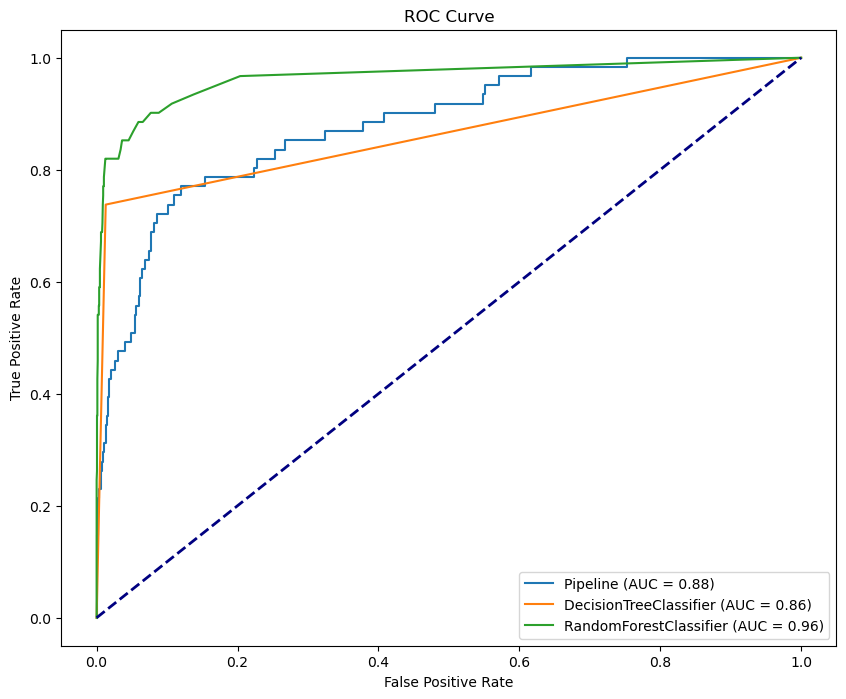

In [308]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate through models, fit, predict, and plot ROC curve
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
plt.show()

# save roc curve
fig.savefig('../img/roc_curve1.png')



**Findings** :
- The `RandomForestClassifier` outperforms both the `Pipeline` and the `DecisionTreeClassifier` with an Area Under Curve (`AUC`) of `0.96`.

### Confusion Matrix can help us compare models' accuracy and overfiting

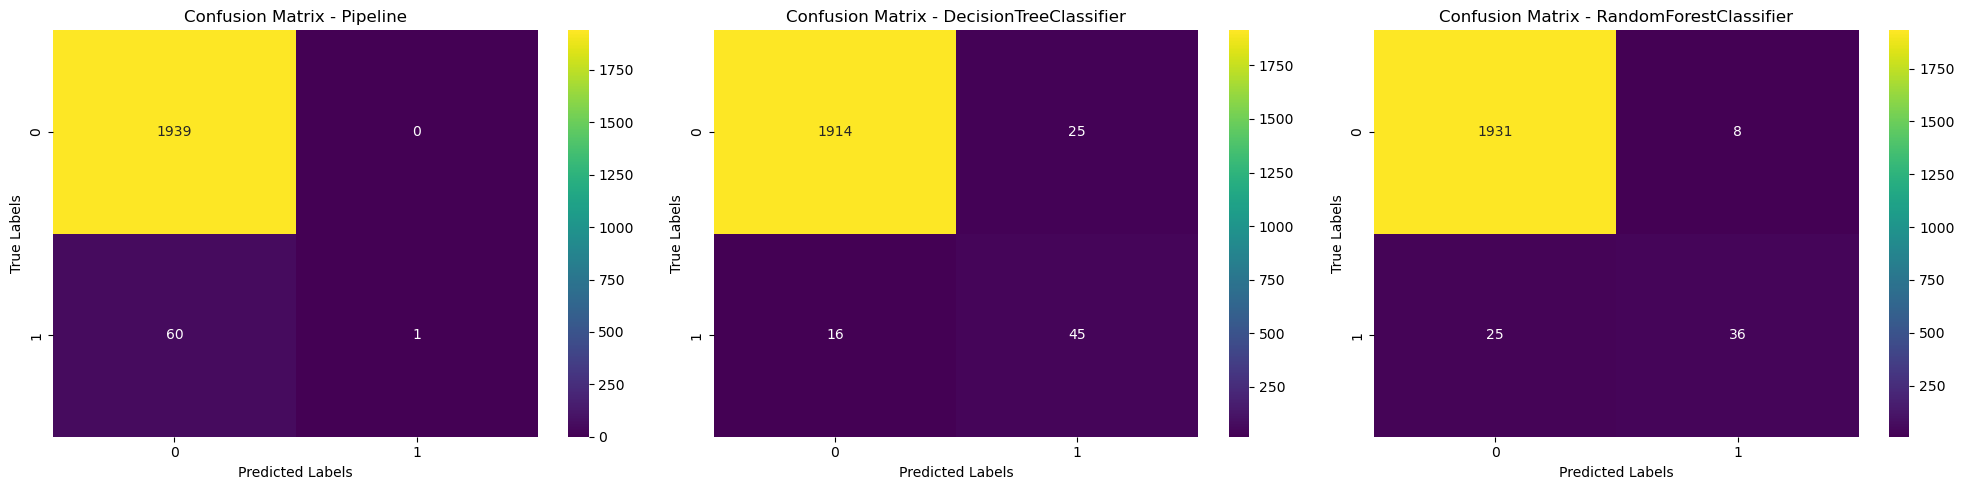

In [309]:
# confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

# Iterate through models, fit, predict, and plot confusion matrix
for i, model in enumerate(models):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    confusion = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='viridis', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Save to img/confusion_matrix.png
fig.savefig('../img/confusion_matrix.png')


## Evaluation Report

**Pipeline**:
- High `AUC`, strong discriminative power (model's ability to accurately distinguish between different classes or outcomes in a dataset.)
- Fails to identify any true negatives, suggesting bias towards positive class predictions.
- High true positives, but zero true negatives could be problematic in high false positive cost scenarios.

**DecisionTreeClassifier**:
- AUC = 0.86, slightly lower than Pipeline.
- More balanced performance; identifies some true negatives.
- Lower false positives than Pipeline, indicating a more conservative classification approach.

**RandomForestClassifier**:
- Highest `AUC (0.96)`, indicating superior discriminative power.
- Balanced classification approach with reasonable true negatives (`TN`) and lowest false negatives (`FN`).
- Effective in identifying positive cases and somewhat effective in recognizing negatives, making it robust for applications needing both sensitivity and specificity.

### Is it possible to pick a threshold where `TPR` is greater than a specified criteria and `FPR` is less than another specified criteria? What is the threshold?

### Steps:
1. Set thresholds
2. Apply thresholds
3. Visualize

In [310]:
def find_threshold_by_criteria(y_test, y_score, tpr_criteria=0.6, fpr_criteria=0.4):
    """
    Find a threshold where TPR is greater than a specified criteria and FPR is less than another specified criteria.

    Parameters:
    - y_test: The true binary labels.
    - y_score: The target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions.
    - tpr_criteria (float): The minimum TPR value desired.
    - fpr_criteria (float): The maximum FPR value allowed.

    Returns:
    - The threshold meeting the specified criteria or None if no such threshold exists.
    """

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

    # Iterate through each FPR, TPR, and threshold
    for f, t, th in zip(fpr, tpr, thresholds):
        if t > tpr_criteria and f < fpr_criteria:
            return th  # Return the threshold once the condition is met

    return None  # Return None if no threshold meets the criteria

# Example usage
tpr_criteria = 0.6
fpr_criteria = 0.4
desired_threshold = find_threshold_by_criteria(y_test, y_score, tpr_criteria, fpr_criteria)
if desired_threshold is not None:
    print(f"Threshold where TPR > {tpr_criteria*100}% and FPR < {fpr_criteria*100}%: {desired_threshold}")
else:
    print(f"No threshold found meeting the criteria of TPR > {tpr_criteria*100}% and FPR < {fpr_criteria*100}%.") 

Threshold where TPR > 60.0% and FPR < 40.0%: 0.47


In [311]:
# Apply the identified threshold to make binary predictions
y_pred = (y_score[:, 1] >= desired_threshold).astype(int)

# Evaluate model performance
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# Save accuracy_score, precision_score, recall_score, f1_score, as an image
metrics = pd.DataFrame({'Accuracy': [accuracy_score(y_test, y_pred)], 'Precision': [precision_score(y_test, y_pred)], 'Recall': [recall_score(y_test, y_pred)], 'F1 Score': [f1_score(y_test, y_pred)]})

# Save the DataFrame as an image
df_styled = metrics.style.background_gradient() # Styling for better visualization
dfi.export(df_styled, '../img/metrics.png')






Accuracy: 0.984
Precision: 0.8085106382978723
Recall: 0.6229508196721312
F1 Score: 0.7037037037037037
Confusion Matrix:
[[1930    9]
 [  23   38]]


**While the model is highly accurate overall, the lower recall suggests it struggles to identify all positive cases, which could be critical in a predictive maintenance context where missing a potential failure could have serious implications.** 
- Thresholds can be manually adjusted to achieve better prediction.

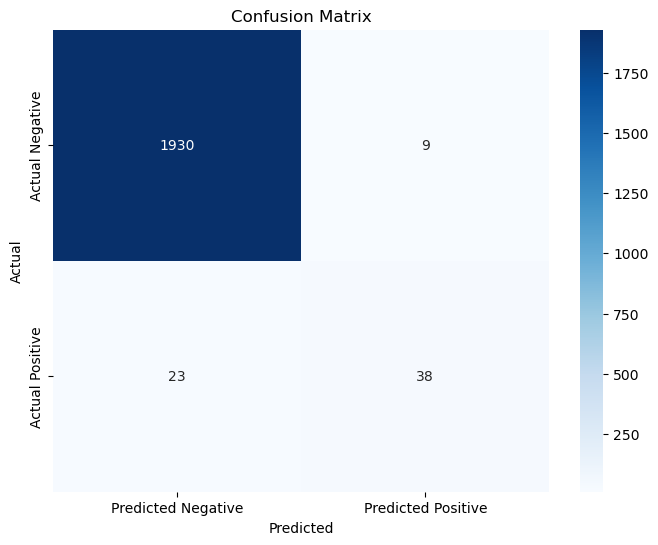

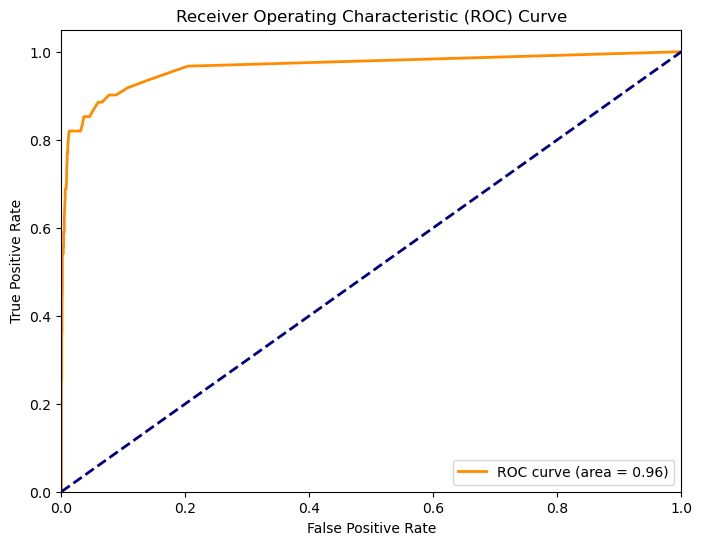

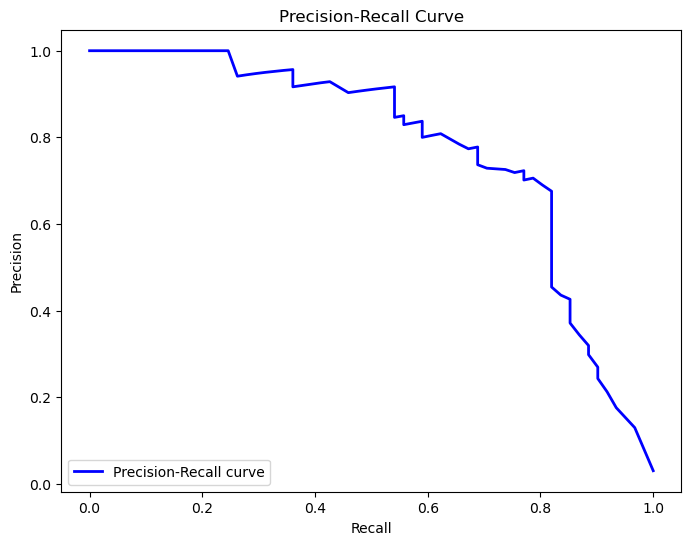

In [312]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()